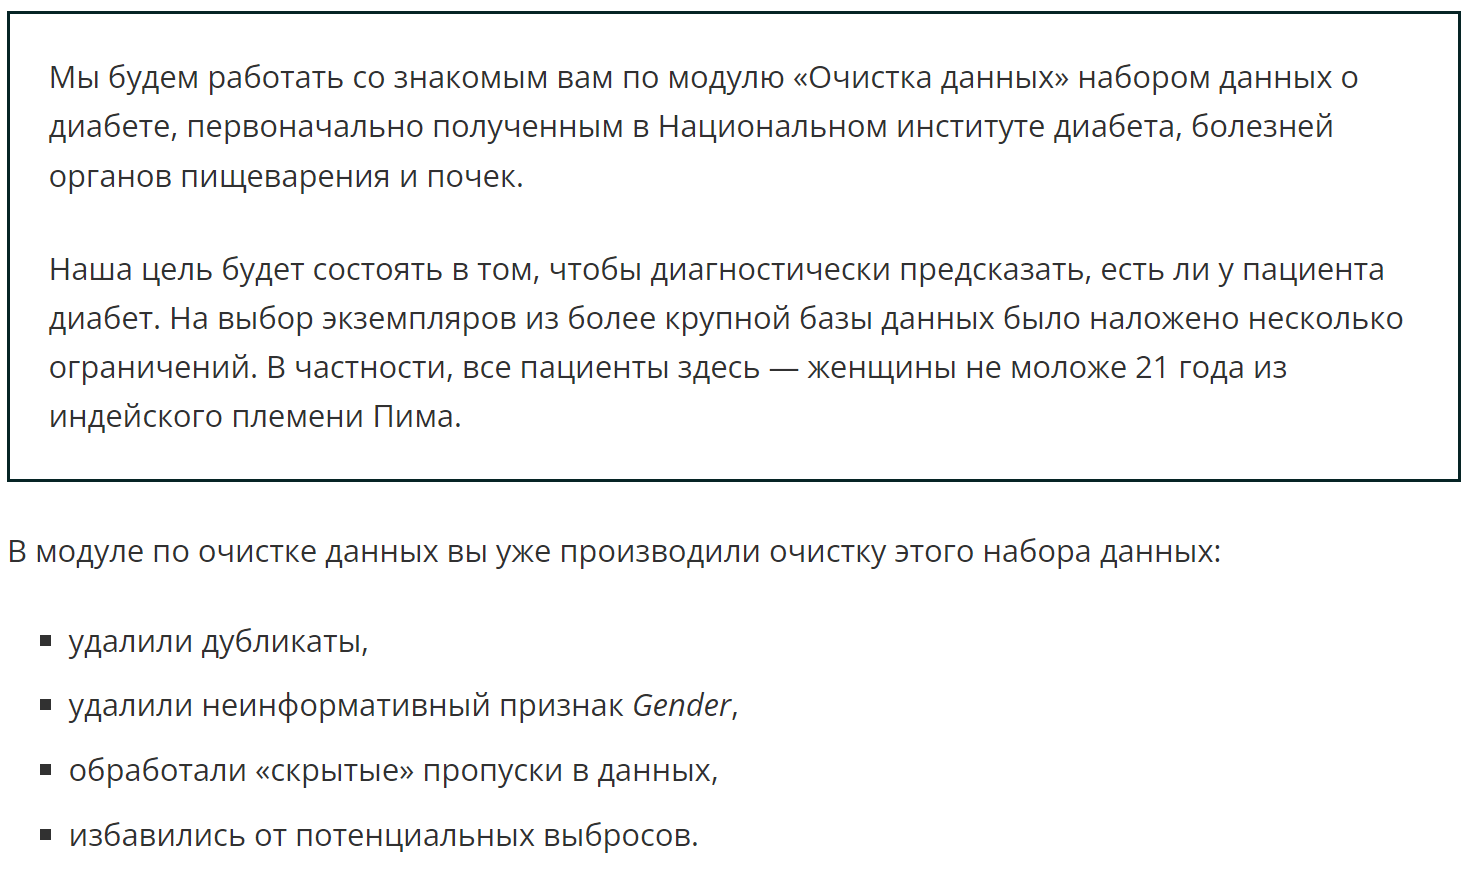

In [114]:
# для автозагрузки изменений в модулях без необходимости перезагрузки kelner
%load_ext autoreload
%autoreload 2

# необходимо для корректного импорта своих модулей в JupyterLab
import sys
current_dir = sys.path[0]
project_dir = 'SF_DS_Pro'
last_position = current_dir.find(project_dir) + len(project_dir)
project_path = current_dir[:last_position]
sys.path.append(project_path)

import Handlers as hd

In [115]:
import numpy as np # для матричных вычислений
import pandas as pd # для анализа и предобработки данных
import matplotlib.pyplot as plt # для визуализации
import seaborn as sns # для визуализации

from sklearn import linear_model # линейные модели
from sklearn import metrics # метрики

from sklearn.model_selection import train_test_split # сплитование выборки
from sklearn import preprocessing # предобработка


%matplotlib inline
plt.style.use('seaborn')
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (10, 8)

## Логистическая регрессия

**Знакомство с данными**

Набор данных вы можете скачать по [ссылке](https://lms.skillfactory.ru/assets/courseware/v1/c21dd892cc0cc4fba3976b2a91559ff0/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/diabetes_cleaned.zip).

In [47]:
diabetes_data = pd.read_csv('data/diabetes_cleaned.zip')
diabetes_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,98.0,58.0,33.0,34.0,0.430,43,0
1,2,112.0,75.0,32.0,35.7,0.148,21,0
2,2,108.0,64.0,29.0,30.8,0.158,21,0
3,8,107.0,80.0,29.0,24.6,0.856,34,0
4,7,136.0,90.0,29.0,29.9,0.210,50,0


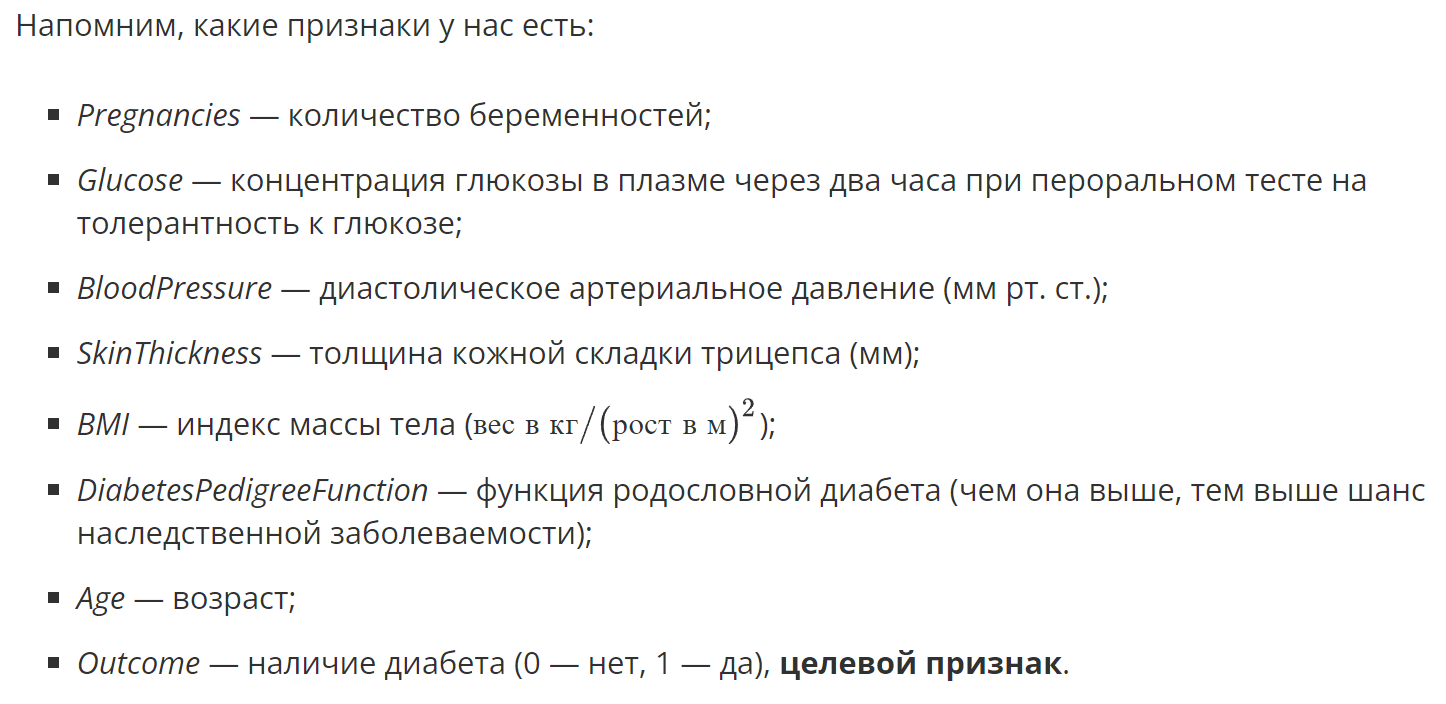

In [48]:
diabetes_data.shape

(757, 8)

Распределение классов целевого признака

In [49]:
diabetes_data['Outcome'].value_counts(True)

Outcome
0    0.651255
1    0.348745
Name: proportion, dtype: float64

Давайте посмотрим на матрицу корреляций и выберем наиболее коррелированные с целевым признаком факторы:

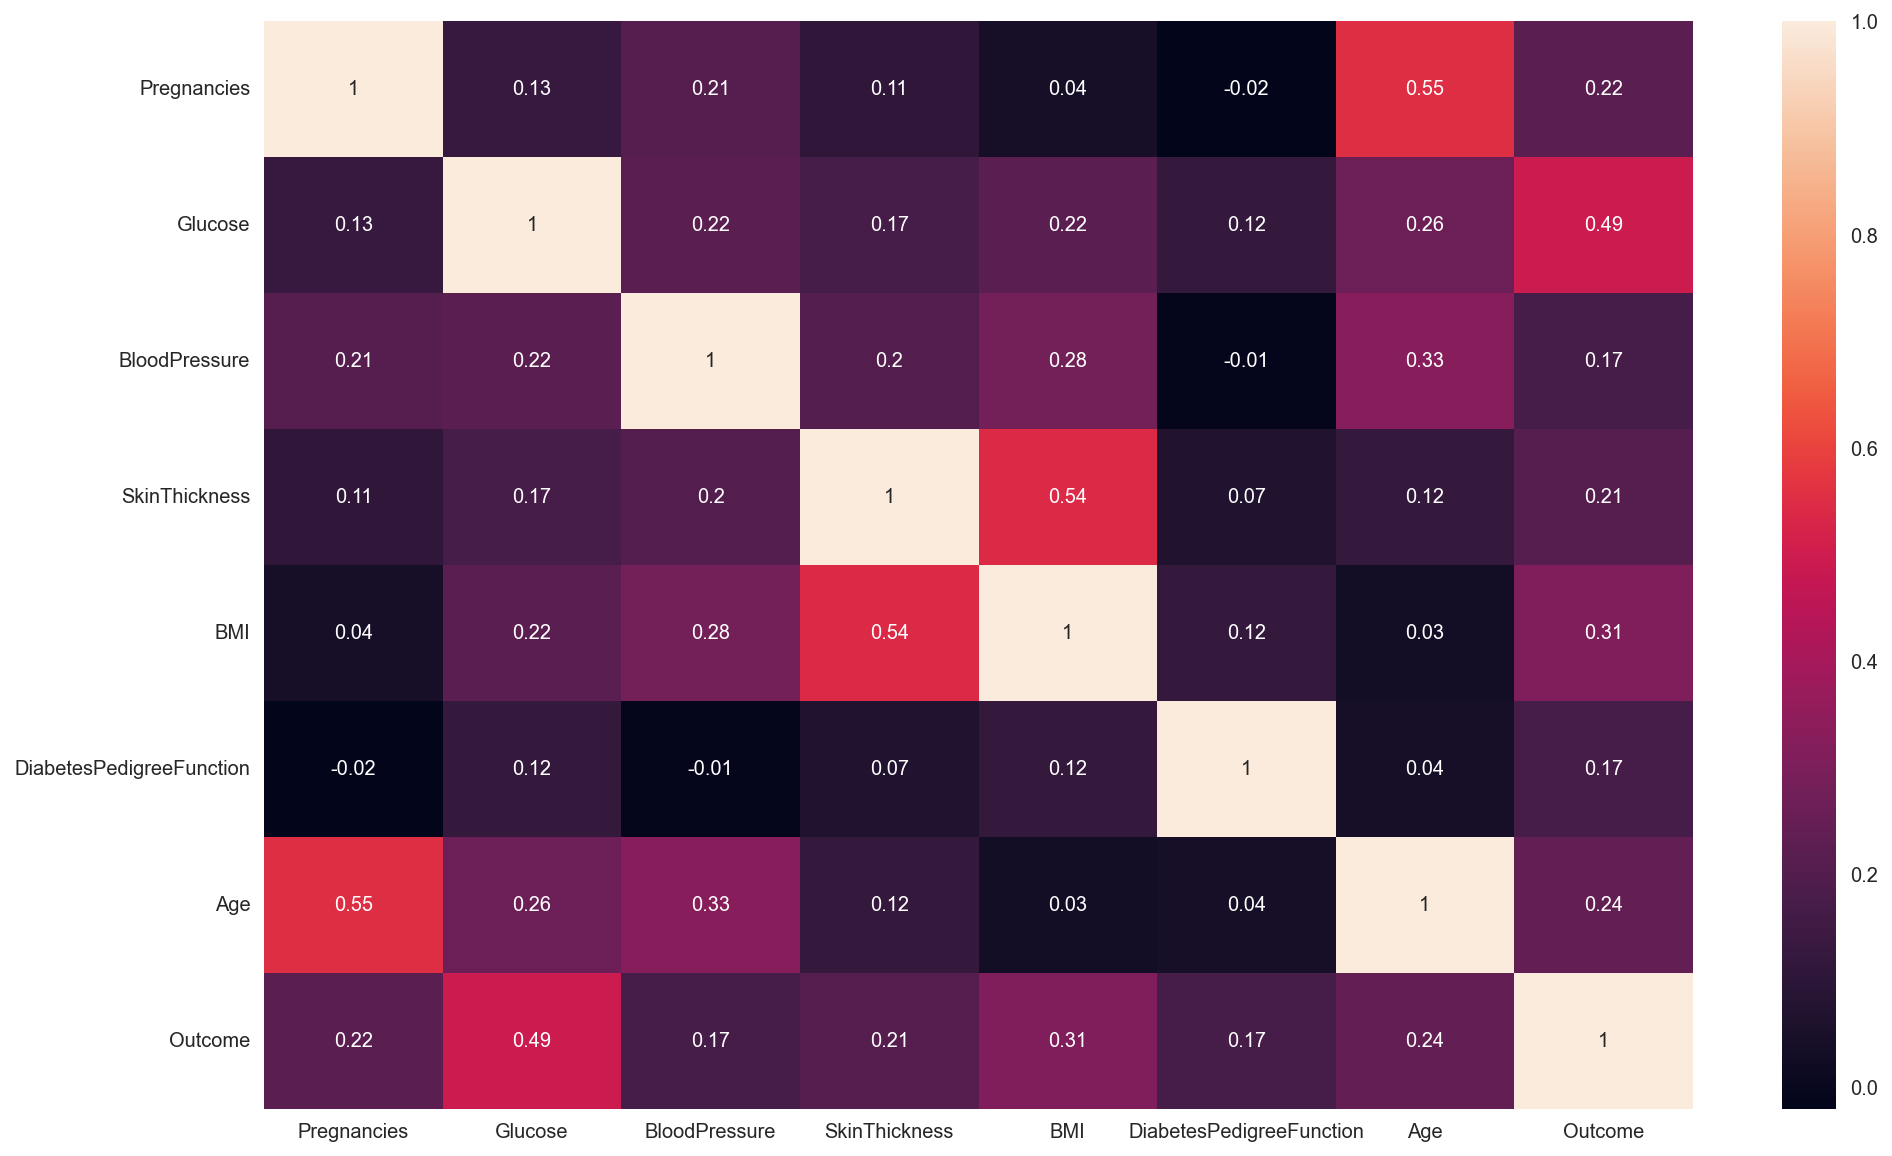

In [50]:
fig, ax = plt.subplots(figsize = (16, 10))
sns.heatmap(diabetes_data.corr().round(2), annot=True);

In [51]:
# Топ 2 наиболее коррелированных признаков
diabetes_data.corr()['Outcome'].drop(index=['Outcome']).sort_values(ascending=False).index.to_list()[:2]

['Glucose', 'BMI']

### Выбираю два признака с наибольшей корреляцией с целевым признаком

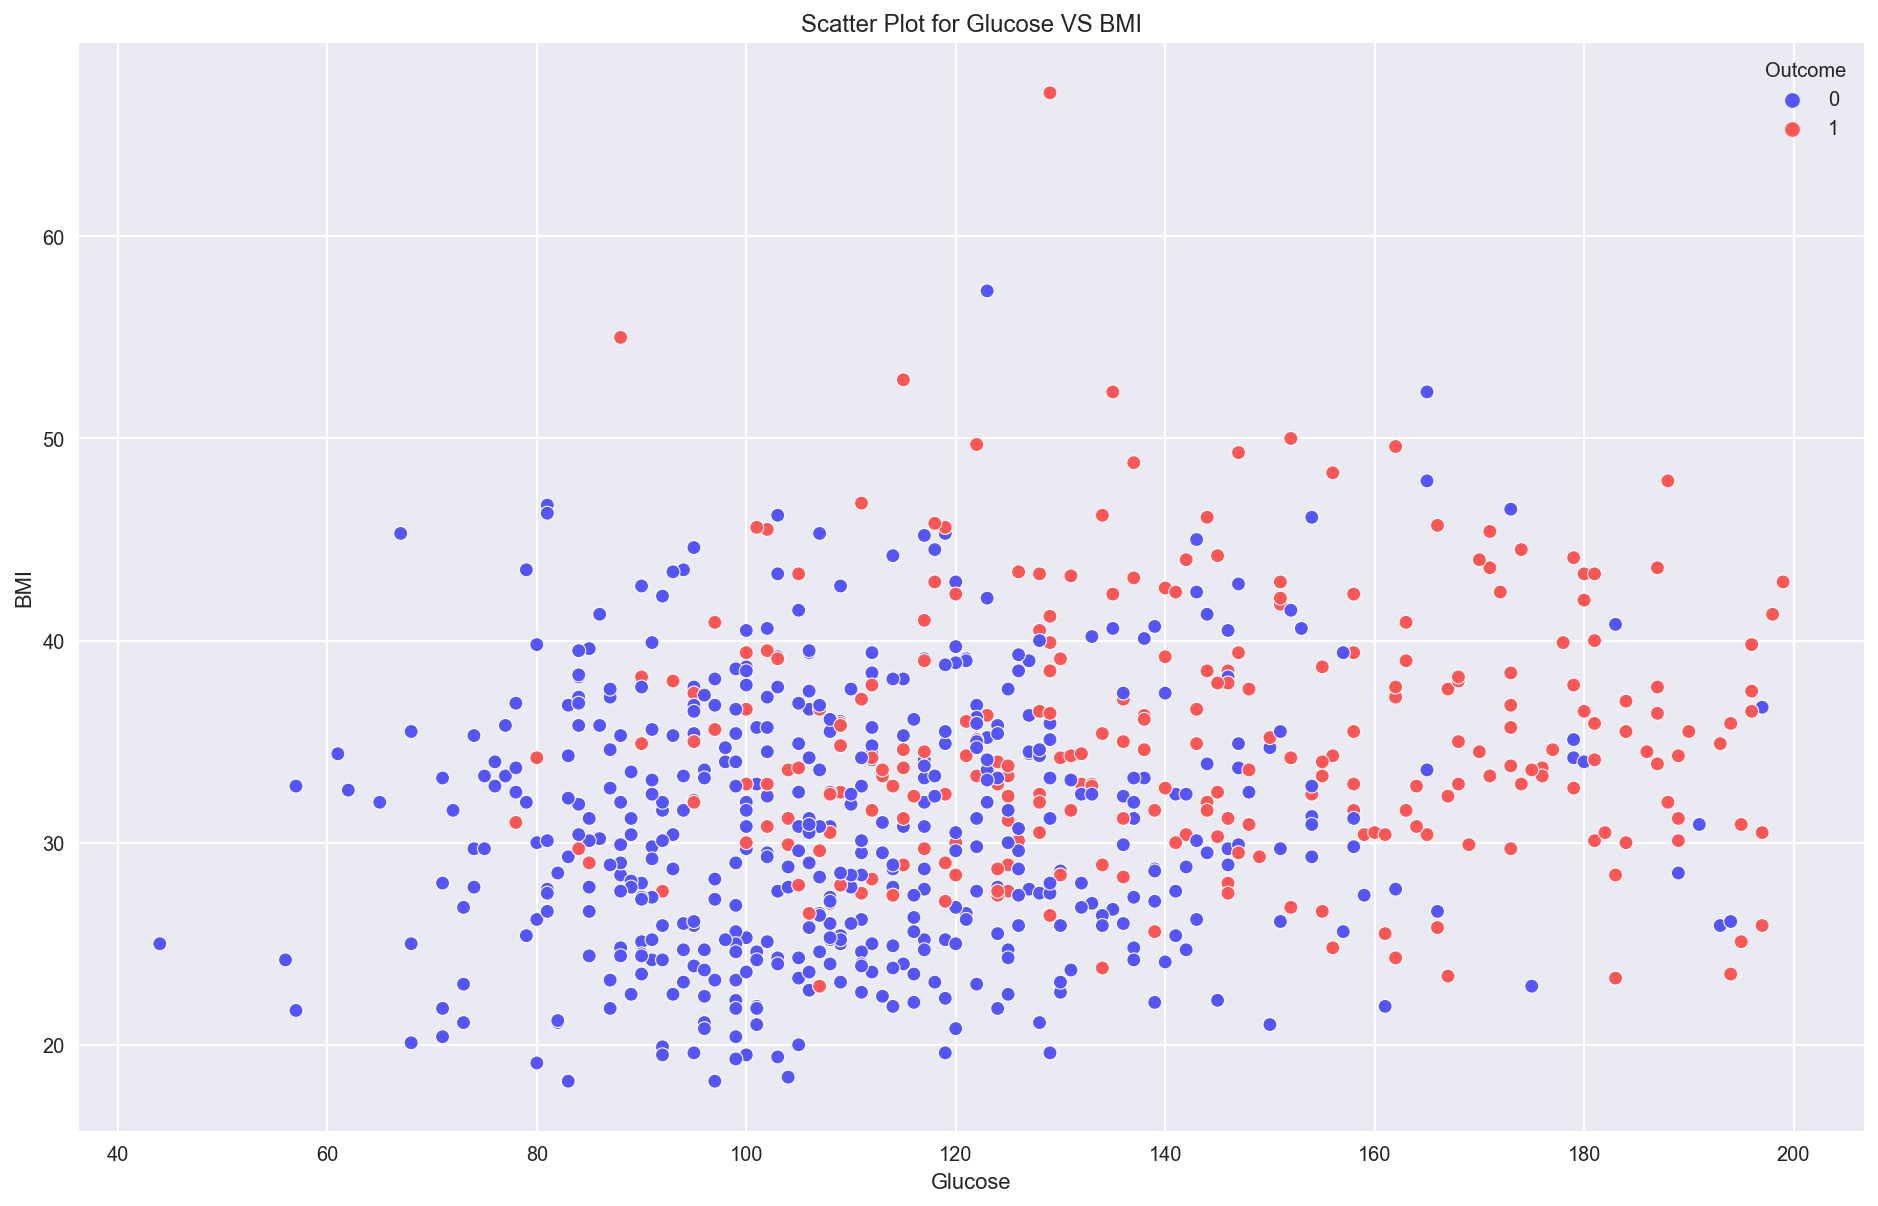

In [52]:
fig, ax = plt.subplots(figsize = (16, 10)) # фигура + координатная плоскость
# Строим диаграмму рассеяния
sns.scatterplot(
    data=diabetes_data, # датасет
    x='Glucose', # ось абсцисс
    y='BMI', # ось ординат
    hue='Outcome', # группировка
    palette='seismic', # палитра
    ax=ax, # координатная плоскость
)
# Задаем название графику
ax.set_title('Scatter Plot for Glucose VS BMI');

In [53]:
# Создаем матрицу наблюдений X и столбец с ответами y
X = diabetes_data[['Glucose', 'BMI']]
y = diabetes_data['Outcome']

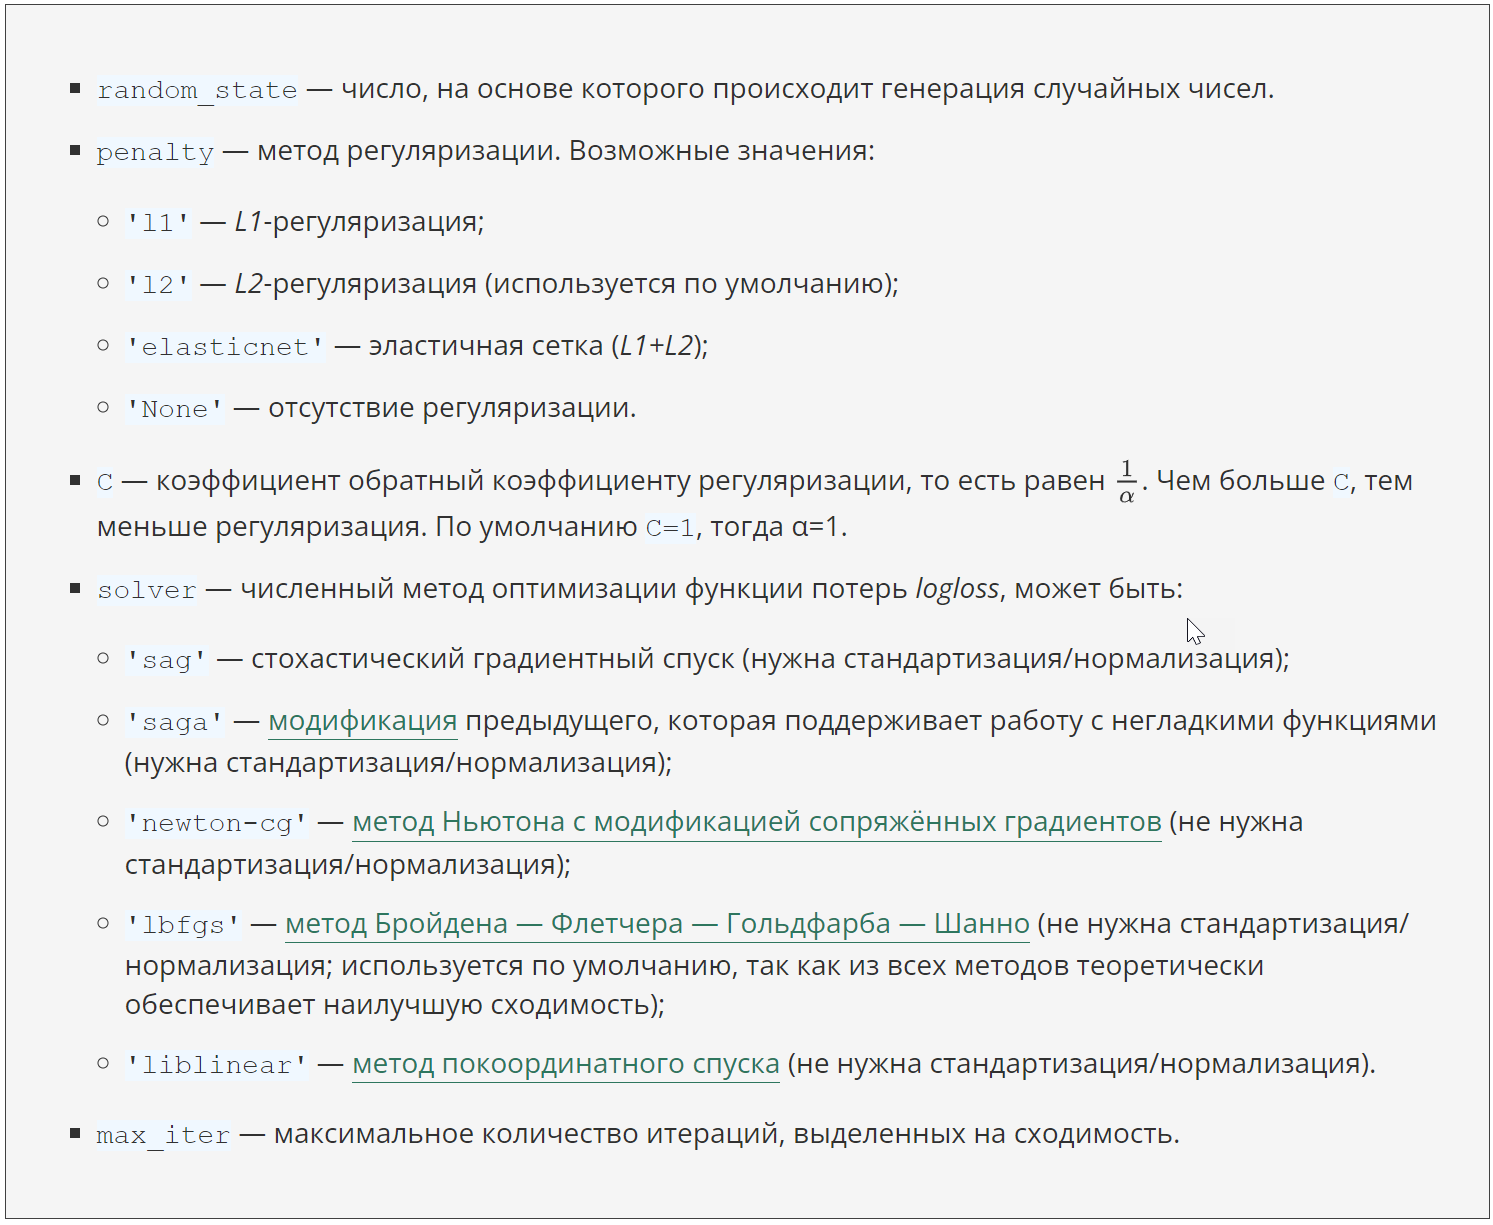

In [54]:
# Создаем объект класса логистическая регрессия
log_reg_2d = linear_model.LogisticRegression(random_state=42)

# Обучаем модель, минизируя logloss 
log_reg_2d.fit(X, y)

# Выводим результирующие коэффициенты
print('w0: {}'.format(log_reg_2d.intercept_)) # свободный член w0
print('w1, w2: {}'.format(log_reg_2d.coef_)) # остальные параметры модели w1, w2, ..., wm

w0: [-8.24898965]
w1, w2: [[0.03779275 0.0875742 ]]


In [55]:
# Значения концентрации глюкозы и индекса массы тела для пациента
x_new = pd.DataFrame({'Glucose': [180], 'BMI': [51]})

# Делаем предсказание вероятностей:
# Вероятность что дипабета нет и что он есть
y_new_proba_predict = log_reg_2d.predict_proba(x_new)
print('Predicted probabilities: {}'.format(np.round(y_new_proba_predict, 2)))

Predicted probabilities: [[0.05 0.95]]


Метод predict_proba() возвращает сразу две вероятности: первая соответствует вероятности принадлежности к классу 0 (диабета нет), а вторая — вероятности принадлежности к классу 1 (диабет есть). Заметьте, что в сумме две вероятности дают 1, что вполне логично, так как события взаимоисключающие.

In [56]:
# Значения концентрации глюкозы и индекса массы тела для пациента
x_new = pd.DataFrame({'Glucose': [180], 'BMI': [51]})

# Делаем предсказание класса:
# Класс объекта. 0 - нет диабета, 1 - есть диабет
y_new_predict = log_reg_2d.predict(x_new)
print('Predicted class: {}'.format(y_new_predict))

Predicted class: [1]


In [57]:
# Функция для визуализации модели
def plot_probabilities_2d(X, y, model):
    """ Функция для визуализации вероятности в виде тепловой карты

    Args:
        X (_type_): матрица с наблюдениями
        y (_type_): вектор правильных ответов
        model (_type_):  модель, с помощью которой делается предсказание вероятностей
    """
    
    # Генерируем координатную сетку из всех возможных значений для признаков
    # Glucose изменяется от x1_min = 44 до x2_max = 199, 
    # BMI - от x2_min = 18.2 до x2_max = 67.1
    # Результат работы функции - два массива xx1 и xx2, которые образуют координатную сетку
    xx1, xx2 = np.meshgrid(
        np.arange(X.iloc[:, 0].min()-1, X.iloc[:, 0].max()+1, 0.1),
        np.arange(X.iloc[:, 1].min()-1, X.iloc[:, 1].max()+1, 0.1)
    )
    #Вытягиваем каждый из массивов в вектор-столбец — reshape(-1, 1)
    #Объединяем два столбца в таблицу с помощью hstack
    X_net = np.hstack([xx1.reshape(-1, 1), xx2.reshape(-1, 1)])
    #Предсказываем вероятность для всех точек на координатной сетке
    #Нам нужна только вероятность класса 1
    probs = model.predict_proba(X_net)[:, 1]
    #Переводим столбец из вероятностей в размер координатной сетки
    probs = probs.reshape(xx1.shape)
    #Создаём фигуру и координатную плоскость
    fig, ax = plt.subplots(figsize = (10, 5))
    #Рисуем тепловую карту вероятностей
    contour = ax.contourf(xx1, xx2, probs, 100, cmap='bwr')
    #Рисуем разделяющую плоскость — линию, где вероятность равна 0.5
    bound = ax.contour(xx1, xx2, probs, [0.5], linewidths=2, colors='black')
    #Добавляем цветовую панель 
    colorbar = fig.colorbar(contour)
    #Накладываем поверх тепловой карты диаграмму рассеяния
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=y, palette='seismic', ax=ax)
    #Даём графику название
    ax.set_title('Scatter Plot with Decision Boundary')
    #Смещаем легенду в верхний левый угол вне графика
    ax.legend(bbox_to_anchor=(-0.05, 1))
    plt.show()

C:\Users\avvoy\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\avvoy\AppData\Local\Temp\ipykernel_18296\2729066159.py:34: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  colorbar = fig.colorbar(contour)


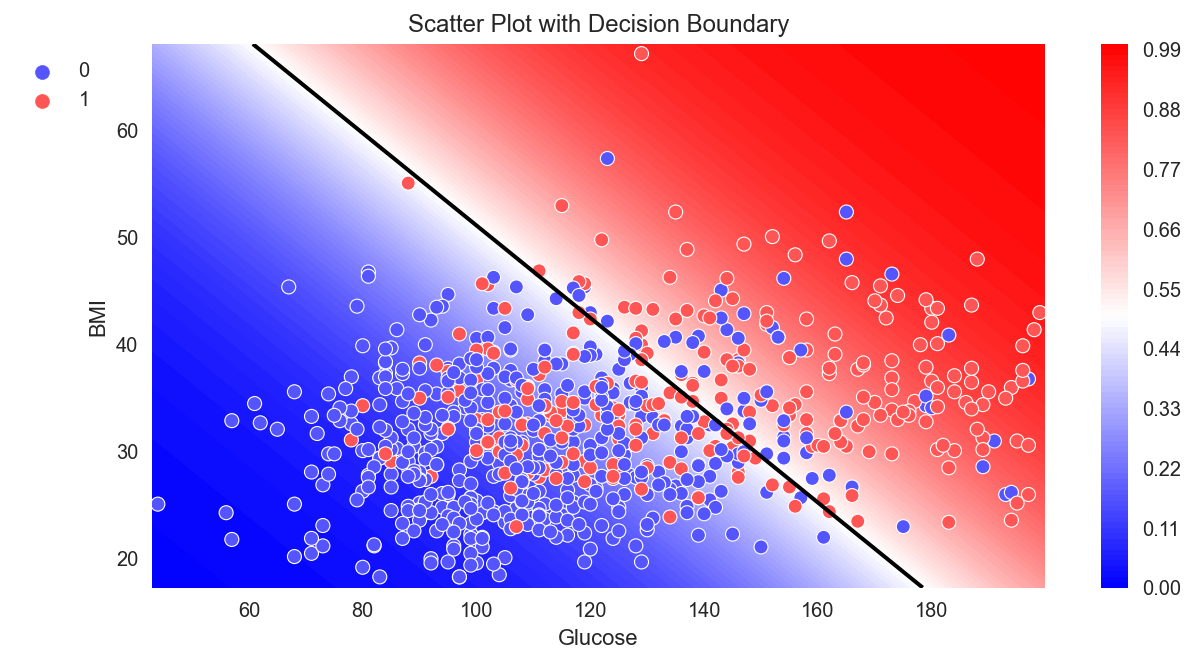

In [58]:
plot_probabilities_2d(X, y, log_reg_2d)

Используем все признаки

In [59]:
# Создаем матрицу признаков X и столбец с ответами y
X = diabetes_data.drop(columns='Outcome')
y = diabetes_data['Outcome']

In [60]:
# Создаем объект класса логистическая регрессия
log_reg_full = linear_model.LogisticRegression(random_state=42, max_iter=1000)

# Обучаем модель, минизируя logloss
log_reg_full.fit(X, y)

# Делаем предсказание класса
y_pred = log_reg_full.predict(X)

# Создадим временную таблицу X
X_temp = X.copy()

# Добавим в эту таблицу результат предсказания
X_temp['Prediction'] = y_pred
X_temp.tail()

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Prediction
752,5,139.0,64.0,35.0,28.6,0.411,26,0
753,1,96.0,122.0,29.0,22.4,0.207,27,0
754,10,101.0,86.0,37.0,45.6,1.136,38,1
755,0,141.0,72.0,29.0,42.4,0.205,29,1
756,0,125.0,96.0,29.0,22.5,0.262,21,0


In [61]:
# Делаем предсказание моделью, обученной на двух факторах 
y_pred1 = log_reg_2d.predict(diabetes_data[['Glucose', 'BMI']])

# Делаем предсказание моделью, обученной на всех факторах 
y_pred2 = log_reg_full.predict(diabetes_data.drop(columns='Outcome'))

## Метрики классификации

In [104]:
# Строим матрицы ошибок для каждой из моделей
confusion_matrix1 = metrics.confusion_matrix(y, y_pred1)
confusion_matrix2 = metrics.confusion_matrix(y, y_pred2)

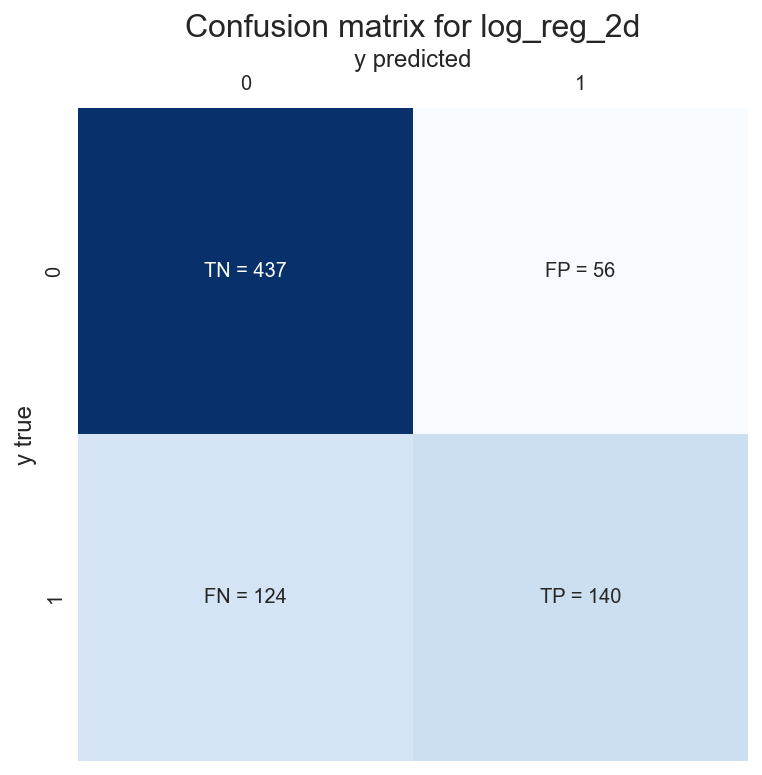

In [116]:
hd.plot_confusion_matrix(confusion_matrix1, 'Confusion matrix for log_reg_2d')

In [111]:
print('Accuracy: {:.2f}'.format(metrics.accuracy_score(y, y_pred1)))
# Рассчитываем precision
print('Precision: {:.2f}'.format(metrics.precision_score(y, y_pred1)))
# Рассчитываем recall
print('Recall: {:.2f}'.format(metrics.recall_score(y, y_pred1)))
# Рассчитываем F1-меру
print('F1 score: {:.2f}'.format(metrics.f1_score(y, y_pred1)))

Accuracy: 0.76
Precision: 0.71
Recall: 0.53
F1 score: 0.61


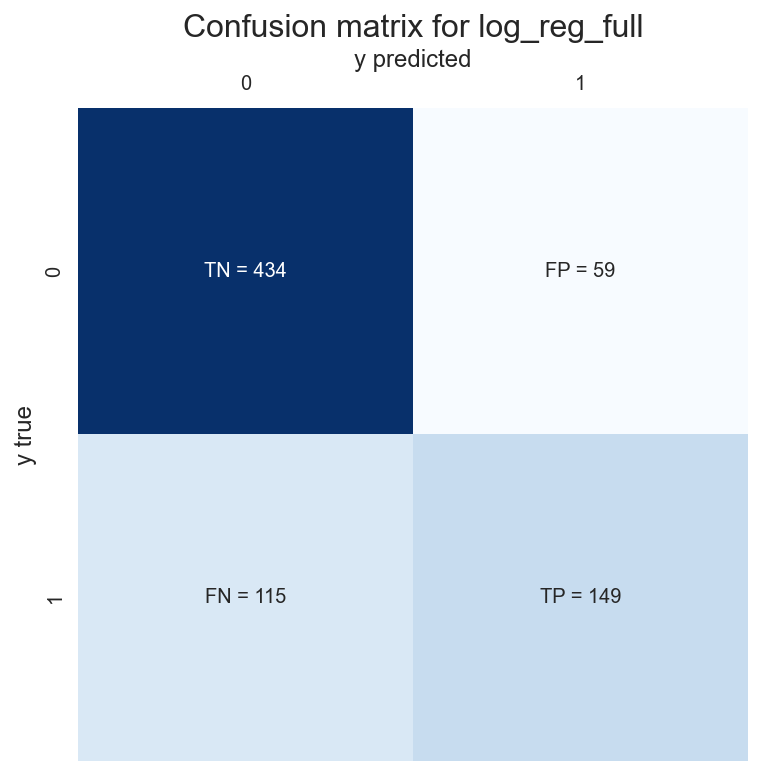

In [117]:
hd.plot_confusion_matrix(confusion_matrix2, 'Confusion matrix for log_reg_full')

In [68]:
# Модель log_reg_2d:
# Рассчитываем accuracy
print('Accuracy: {:.2f}'.format(metrics.accuracy_score(y, y_pred1)))
# Рассчитываем precision
print('Precision: {:.2f}'.format(metrics.precision_score(y, y_pred1)))
# Рассчитываем recall
print('Recall: {:.2f}'.format(metrics.recall_score(y, y_pred1)))
# Рассчитываем F1-меру
print('F1 score: {:.2f}'.format(metrics.f1_score(y, y_pred1)))

Accuracy: 0.76
Precision: 0.71
Recall: 0.53
F1 score: 0.61


In [69]:
# Модель log_reg_full:
# Рассчитываем accuracy
print('Accuracy: {:.2f}'.format(metrics.accuracy_score(y, y_pred2)))
# Рассчитываем precision
print('Precision: {:.2f}'.format(metrics.precision_score(y, y_pred2)))
# Рассчитываем recall
print('Recall: {:.2f}'.format(metrics.recall_score(y, y_pred2)))
# Рассчитываем F1-меру
print('F1 score: {:.2f}'.format(metrics.f1_score(y, y_pred2)))

Accuracy: 0.77
Precision: 0.72
Recall: 0.56
F1 score: 0.63


In [70]:
print(metrics.classification_report(y, y_pred1))

              precision    recall  f1-score   support

           0       0.78      0.89      0.83       493
           1       0.71      0.53      0.61       264

    accuracy                           0.76       757
   macro avg       0.75      0.71      0.72       757
weighted avg       0.76      0.76      0.75       757



In [71]:
print(metrics.classification_report(y, y_pred2))

              precision    recall  f1-score   support

           0       0.79      0.88      0.83       493
           1       0.72      0.56      0.63       264

    accuracy                           0.77       757
   macro avg       0.75      0.72      0.73       757
weighted avg       0.76      0.77      0.76       757



### Настройка порога вероятности
Сделаем предсказание вероятности наличия диабета моделью log_reg_full для каждого пациента из нашей выборки. Затем создадим несколько различных порогов вероятности в диапазоне от 0.1 до 1 с шагом 0.05. В цикле будем определять класс пациента при различных порогах вероятности. В конце рассчитаем метрики.

In [72]:
# Считаем вероятности наличия диабета для каждого из пациентов
# Тут берем таблицу вероятностей и интересует только вероятность класса 1 (второй столбец)
y_proba_pred = log_reg_full.predict_proba(diabetes_data.drop(columns='Outcome'))[:, 1]

# Для удобства завернем numpy-массив в pandas Series
y_proba_pred = pd.Series(y_proba_pred)

# Создадим списки, в которых будем хранить значения метрик
precision_scores = []
recall_scores = []
f1_scores = []

# Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)

# В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    # Пациентов, для которых вероятность наличия диабета > threshold относим к классу 1
    # В противном случае - к классу 0
    y_pred = y_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    
    # Считаем метрики и добавляем их в списки
    precision_scores.append(metrics.precision_score(y, y_pred))
    recall_scores.append(metrics.recall_score(y, y_pred))
    f1_scores.append(metrics.f1_score(y, y_pred))

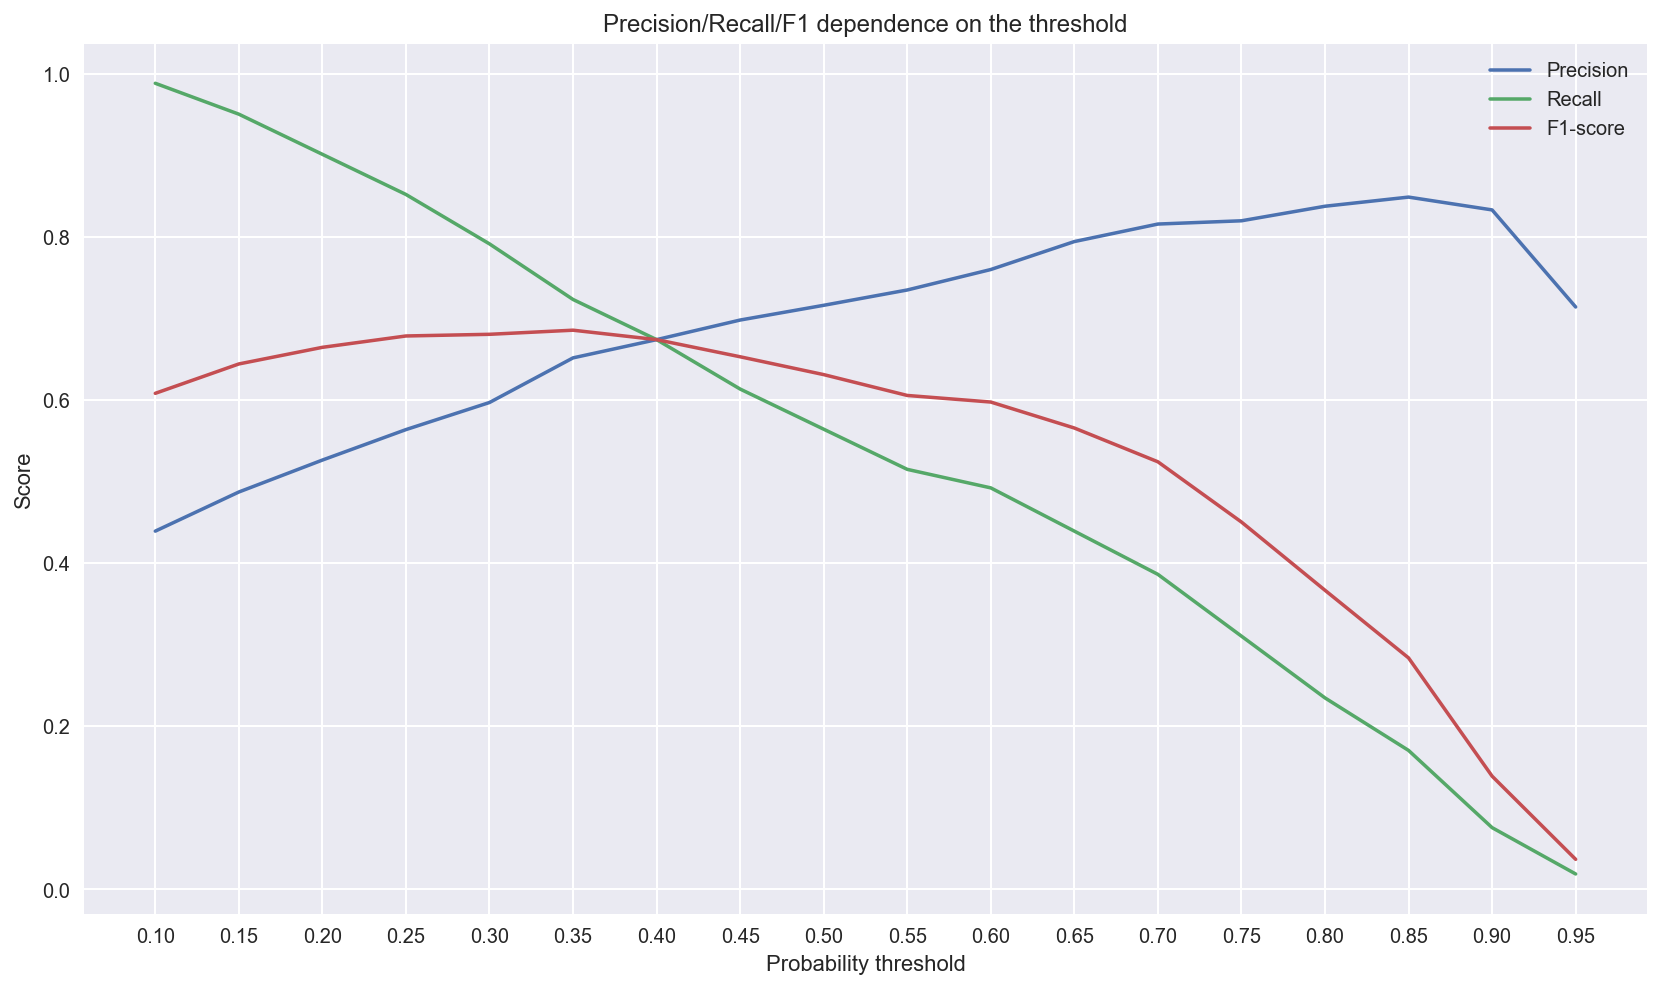

In [73]:
# Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(14, 8)) # фигура + координатная плоскость
# Строим линейный график зависимости precision от threshold
ax.plot(thresholds, precision_scores, label='Precision')
# Строим линейный график зависимости recall от threshold
ax.plot(thresholds, recall_scores, label='Recall')
# Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')

# Даем графику название и подписи осям
ax.set_title('Precision/Recall/F1 dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
# Устанавливаем отметки по оси x
ax.set_xticks(thresholds) 
# Отображаем легенду
ax.legend();

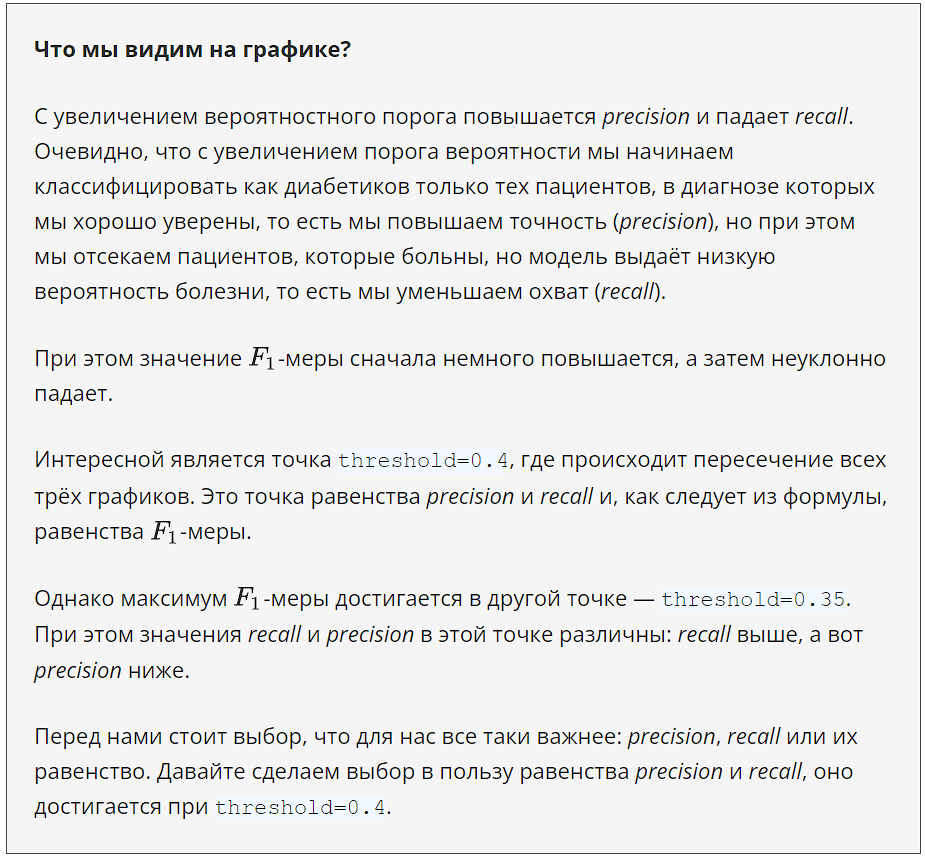

Как теперь мы можем сделать предсказание класса, обладая данной информацией?

Мы делаем предсказание вероятности наличия диабета для всех пациентов, 

а затем вручную определяем всех пациентов, у которых эта вероятность > 0.4, 

в класс 1, а остальных — в класс 0

In [74]:
# Задаем оптимальный порог вероятностей
threshold_opt = 0.4
# Пациентов, для которых вероятность наличия диабета > 0.35 относим к классу 1
# В противном случае - к классу 0
y_pred_opt = y_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
# Считаем метрики
print(metrics.classification_report(y, y_pred_opt))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83       493
           1       0.67      0.67      0.67       264

    accuracy                           0.77       757
   macro avg       0.75      0.75      0.75       757
weighted avg       0.77      0.77      0.77       757



In [75]:
metrics.f1_score(y, y_pred_opt)

0.6742424242424242

Реализация полноценной версии F-меры с возможностью указывать бету

In [118]:
hd.fB_score(y, y_pred_opt, 1)

0.6742424242424242